In [1]:
# import required modules
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
!pip install kaggle

In [3]:
#for Kaggle API 

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [4]:
#download the dataset
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

twitter-entity-sentiment-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#unziping required files
!unzip /content/twitter-entity-sentiment-analysis.zip

Archive:  /content/twitter-entity-sentiment-analysis.zip
replace twitter_training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: twitter_training.csv    
replace twitter_validation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: twitter_validation.csv  


In [6]:
# Reading the data
df_train =  pd.read_csv("/content/twitter_training.csv", names = ['id', 'user','sentiment','text'], header = None)
df_val = pd.read_csv("/content/twitter_validation.csv", names = ['id', 'user','sentiment','text'], header = None)

df_train.head(5)

,id,user,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
df_val.head(5)

,id,user,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [8]:
# There are total 4 class in the dataset
df_train['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [9]:
# check in for null values
df_train.isnull().sum()

id             0
user           0
sentiment      0
text         686
dtype: int64

In [10]:
df_val.isnull().sum()

id           0
user         0
sentiment    0
text         0
dtype: int64

In [11]:
# drop the rows with null values in text column becaues it is our input data.
df_train.dropna(inplace = True)
df_train.isnull().sum()

id           0
user         0
sentiment    0
text         0
dtype: int64

In [12]:
df_train.shape, df_val.shape

((73996, 4), (1000, 4))

In [13]:
# dividing the dataset into input, label columns
X_train = df_train['text'].copy()
y_train = df_train['sentiment'].copy()
X_val = df_val['text'].copy()
y_val = df_val['sentiment'].copy()
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((73996,), (73996,), (1000,), (1000,))

In [14]:
# cleaning the data 
X_train = X_train.replace(
        # remove users tagged in the data
        to_replace ='@\w+', value = '', regex = True
    ).replace(
        # remove links starting with https in the data
        to_replace ='https?://\S+', value = '', regex = True
    ).replace(
        # remove links starting with www in the data
        to_replace ='www\.\S+', value = '', regex = True
    ).replace(
        # remove punctuation and extra characters in the data
        to_replace= '[^\w\s]', value='', regex = True
        # convert to lower case.
    ).str.lower()
# same process for validation data
X_val = X_val.replace(
        to_replace ='@\w+', value = '', regex = True
    ).replace(
        to_replace ='https?://\S+', value = '', regex = True
    ).replace(
        to_replace ='www\.\S+', value = '', regex = True
    ).replace(
        to_replace= '[^\w\s]', value='', regex = True
    ).str.lower()

X_train.head(10)

0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
2    im getting on borderlands and i will kill you all
3    im coming on borderlands and i will murder you...
4    im getting on borderlands 2 and i will murder ...
5    im getting into borderlands and i can murder y...
6    so i spent a few hours making something for fu...
7    so i spent a couple of hours doing something f...
8    so i spent a few hours doing something for fun...
9    so i spent a few hours making something for fu...
Name: text, dtype: object

In [15]:
# basic information of the dataset
no_samples = 73996
no_classes = 4
samples_per_class = y_train.value_counts().mean()
words_per_sample = X_train.map(lambda x: len(x.split())).mean()
# if ratio less than 1500 then used n-grams and if greater than 1500 then used sequences.
ratio = no_samples/words_per_sample
ratio

4075.680692910854

In [16]:
from tensorflow.keras.preprocessing import text,sequence
# total no of feature to include.
top_k = 20000
# the max length of the sequence.
max_sequence_length = 500

def sequence_vectorize(train_text, val_text):
    # tokenize the word into respective tokens.
    tokenizer = text.Tokenizer(num_words=top_k)
    tokenizer.fit_on_texts(train_text)
    # convert the sentences into sequence of tokens.
    x_train = tokenizer.texts_to_sequences(train_text)
    x_val = tokenizer.texts_to_sequences(val_text)
    # max length of the sequences obtained
    max_length = len(max(x_train, key=len))
    # if max length less than 500 then take the max_length otherwise set it to 500.
    if max_length > max_sequence_length:
        max_length = max_sequence_length
    # padding all the sequences to a fixed length of max_length
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    
    return x_train, x_val, tokenizer.word_index

In [17]:
X_train, X_val, word_tokens = sequence_vectorize(X_train, X_val)
X_train.shape, X_val.shape

((73996, 166), (1000, 166))

In [18]:
# words and its respective tokens
list(word_tokens.items())[:10]

[('the', 1),
 ('i', 2),
 ('to', 3),
 ('and', 4),
 ('a', 5),
 ('of', 6),
 ('is', 7),
 ('for', 8),
 ('in', 9),
 ('this', 10)]

In [19]:
# one hot encoding the catagorical variables.
y_train = pd.get_dummies(y_train)

In [20]:
y_train.head()

,Irrelevant,Negative,Neutral,Positive
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [21]:
y_val = pd.get_dummies(y_val)
y_val.head()

,Irrelevant,Negative,Neutral,Positive
0,1,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0


In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def cnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_features):
    model = Sequential()
    # using embedding to get a dense vector space.
    model.add(layers.Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                              name= 'embedding'))
    # adding CNN layers and dropout layer to prevent overfitting
    for _ in range(blocks-1):
        model.add(layers.Dropout(rate=dropout_rate))
        model.add(layers.SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dropout(rate=dropout_rate))
    # softmax function for classification.
    model.add(layers.Dense(4, activation='softmax'))
    
    return model


In [23]:
# initializing the model
mymodel = cnn_model(blocks=2,
                 filters= 32,
                 kernel_size = 3,
                 embedding_dim = 200,
                 dropout_rate = 0.4,
                 pool_size = 2,
                 input_shape = (X_train.shape[1],1),
                 num_features = 20000)
# Adam optimizer and metrics for evaluation.
mymodel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
               loss = 'categorical_crossentropy',
               metrics = ['categorical_accuracy'])
mymodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 166, 200)          4000000   
                                                                 
 dropout (Dropout)           (None, 166, 200)          0         
                                                                 
 separable_conv1d (Separable  (None, 166, 32)          7032      
 Conv1D)                                                         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 83, 32)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 83, 32)            0         
                                                                 
 separable_conv1d_1 (Separab  (None, 83, 64)           2

In [24]:
from tensorflow.keras import callbacks
# callback to stop the model from overfitting and restore the best weights when it tends to overfit
callback = callbacks.EarlyStopping(patience = 5,
                                  min_delta = 0.001,
                                  restore_best_weights = True)

In [25]:
# training the model in the train data and validation using validation data
history = mymodel.fit(X_train, y_train,
         validation_data = (X_val, y_val),
         batch_size = 1024,
         epochs = 15,
         callbacks = [callback])

Epoch 1/15
73/73 [==============================] - 11s 118ms/step - loss: 1.3688 - categorical_accuracy: 0.2972 - val_loss: 1.3718 - val_categorical_accuracy: 0.2660
Epoch 2/15
73/73 [==============================] - 8s 107ms/step - loss: 1.3670 - categorical_accuracy: 0.3014 - val_loss: 1.3735 - val_categorical_accuracy: 0.2660
Epoch 3/15
73/73 [==============================] - 8s 107ms/step - loss: 1.2411 - categorical_accuracy: 0.4093 - val_loss: 0.9097 - val_categorical_accuracy: 0.6650
Epoch 4/15
73/73 [==============================] - 8s 107ms/step - loss: 0.8524 - categorical_accuracy: 0.6613 - val_loss: 0.4218 - val_categorical_accuracy: 0.8650
Epoch 5/15
73/73 [==============================] - 8s 104ms/step - loss: 0.5450 - categorical_accuracy: 0.7991 - val_loss: 0.2548 - val_categorical_accuracy: 0.9240
Epoch 6/15
73/73 [==============================] - 8s 105ms/step - loss: 0.4147 - categorical_accuracy: 0.8452 - val_loss: 0.2326 - val_categorical_accuracy: 0.9250
Epo

In [26]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


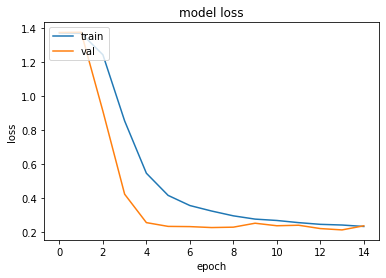

In [27]:
from matplotlib import pyplot as plt
# plotting the loss over time for evaluation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

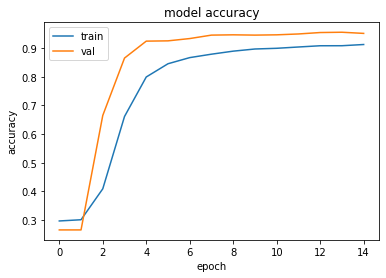

In [28]:
# plotting the accuracy over time for evaluation
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
x_data = X_val[:5].copy()
y_data = y_val[:5].copy()

x_data.shape , y_data.shape

((5, 166), (5, 4))

In [32]:
y_data

,Irrelevant,Negative,Neutral,Positive
0,1,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0


In [34]:
predictions = mymodel.predict(x_data)

predictions > 0.9

array([[ True, False, False, False],
       [False, False,  True, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False, False,  True, False]])